In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoConfig
from transformers import AutoModelForTokenClassification
import torch
import numpy as np
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print(torch.backends.mps.is_available())

2.7.0
CUDA available: False
True


# Data Loading

In [2]:
df = pd.read_csv("subsequences_dataset.csv")
df["label"] = df["label"].astype(float)


train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
df.head()
test_df.shape


(13096, 6)

In [3]:
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species")

def tokenize(batch):
    return tokenizer(batch["sequence"], padding="max_length", truncation=True, max_length=512)


# Data Prep

In [4]:
from datasets import Dataset
from pprint import pprint

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

def preprocess_labels(batch):
    seq_len = len(batch['input_ids'][0])
    batch['labels'] = np.array([[l]*seq_len for l in batch['label']])
    return batch

train_ds = train_ds.map(preprocess_labels, batched=True)
val_ds = val_ds.map(preprocess_labels, batched=True)
test_ds = test_ds.map(preprocess_labels, batched=True)

def broadcast_labels(batch):
    # Number of tokens in each example
    seq_len = len(batch['input_ids'][0])
    
    # Create token-level labels by repeating the sequence label
    token_labels = []
    for l in batch['label']:
        token_labels.append([l] * seq_len)
        
    batch['labels'] = token_labels
    return batch

# Apply after tokenization
train_ds = train_ds.map(broadcast_labels, batched=True)
val_ds = val_ds.map(broadcast_labels, batched=True)
test_ds = test_ds.map(broadcast_labels, batched=True)


Map:   0%|          | 0/61114 [00:00<?, ? examples/s]

Map:   0%|          | 0/13096 [00:00<?, ? examples/s]

Map:   0%|          | 0/13096 [00:00<?, ? examples/s]

Map:   0%|          | 0/61114 [00:00<?, ? examples/s]

Map:   0%|          | 0/13096 [00:00<?, ? examples/s]

Map:   0%|          | 0/13096 [00:00<?, ? examples/s]

Map:   0%|          | 0/61114 [00:00<?, ? examples/s]

Map:   0%|          | 0/13096 [00:00<?, ? examples/s]

Map:   0%|          | 0/13096 [00:00<?, ? examples/s]

In [5]:
# Set format for PyTorch, including 'labels' (plural!)
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "contig"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "contig"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "contig"])

for i in range(3):
    pprint(train_ds[i])
print(train_ds[0]["labels"].dtype)  # Should be torch.float32

train_ds[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0

{'contig': 'NZ_AGLC01000105.1',
 'input_ids': tensor([   3,  632, 1350,  332, 1501, 2460,  329, 2139, 1079,   17, 1161,  919,
         3714, 3447, 1351,  163, 2263,   50,  384, 1420,  214,  671,  207, 1500,
           82,  634,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,  

In [6]:
print("Label distribution:")
print(df['label'].value_counts())
print("Label dtype:", df['label'].dtype)

Label distribution:
label
1.0    43653
0.0    43653
Name: count, dtype: int64
Label dtype: float64


In [7]:
config = AutoConfig.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species")
config.num_labels = 2
config.problem_type = "single_label_classification"

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model = AutoModelForTokenClassification.from_config(config)
model.to(device)

mps


EsmForTokenClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4107, 512, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_feature

In [8]:
N_train = 1000
N_val = 200

train_subset = train_ds.select(range(N_train))
val_subset = val_ds.select(range(N_val))

train_subset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_subset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Training/Eval Model

In [9]:
from transformers import TrainerCallback

class LossLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, **kwargs):
        if 'train_loss' in kwargs.get('logs', {}):
            print(f"Step {state.global_step}: Train Loss = {kwargs['logs']['train_loss']:.4f}")

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

def compute_metrics(p):
    # logits shape: (batch, seq_len, num_labels)
    logits = p.predictions
    probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)  # softmax

    # token predictions (0=bacteria, 1=human)
    token_preds = probs.argmax(-1)  # shape: (batch, seq_len)

    # Compute the percentage of human tokens per sequence
    human_token_pct = token_preds.sum(axis=1) / token_preds.shape[1]

    # Sequence-level predictions using 20% rule
    seq_preds = (human_token_pct >= 0.2).astype(int)

    # Sequence-level ground truth: first token label
    seq_labels = p.label_ids[:, 0].astype(int)

    # Metrics
    acc = accuracy_score(seq_labels, seq_preds)
    f1 = f1_score(seq_labels, seq_preds, average='binary')

    # Identify failures
    failures = []
    for i, (pred, label, pct, tokens) in enumerate(zip(seq_preds, seq_labels, human_token_pct, token_preds)):
        if pred != label:
            failures.append({
                "sequence_index": i,
                "predicted": int(pred),
                "true_label": int(label),
                "human_token_pct": float(pct),
                "token_preds": tokens.tolist()
            })

    return {
        "accuracy": acc,
        "f1": f1,
        "failures": failures
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    #logging_steps=10,  # Log every 10 steps
    #logging_strategy="steps",  # Add this
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    learning_rate=1e-5,  # Lower learning rate
    warmup_steps=400,    # Add warmup
    lr_scheduler_type="cosine",  # Decay learning rate
    metric_for_best_model="f1",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[LossLoggingCallback()] 
)


In [12]:
trainer.train()

/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computa

Step 9550: Train Loss = 0.0935


TrainOutput(global_step=9550, training_loss=0.09349204952180074, metrics={'train_runtime': 18730.1577, 'train_samples_per_second': 16.314, 'train_steps_per_second': 0.51, 'total_flos': 3.5515956410271744e+16, 'train_loss': 0.09349204952180074, 'epoch': 5.0})

# Testing Model

In [24]:
eval_results = trainer.predict(val_ds)  # or test_ds if you have one

logits = eval_results.predictions
labels = eval_results.label_ids

# Softmax
probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)

# Token-level predictions
token_preds = probs.argmax(-1)  # shape (batch, seq_len)

# Sequence-level predictions (20% rule)
seq_preds = (token_preds.sum(axis=1) >= 0.2 * token_preds.shape[1]).astype(int)

# True labels (robust way to get them)
seq_labels = np.array([lbl[lbl != -100][0] for lbl in labels])  # skip padding

fail_indices = np.where(seq_preds != seq_labels)[0]
success_indices = np.where(seq_preds == seq_labels)[0]

print(f"Total sequences: {len(seq_labels)}")
print(f"Failures: {len(fail_indices)}")
print(f"Successes: {len(success_indices)}")


/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Total sequences: 13096
Failures: 522
Successes: 12574


In [13]:
best_model_path = "./results/checkpoint-5730"
print(best_model_path)

./results/checkpoint-5730


In [14]:
from transformers import AutoConfig

# Load config from checkpoint
checkpoint_config = AutoConfig.from_pretrained(best_model_path)
print('Checkpoint intermediate_size:', getattr(checkpoint_config, 'intermediate_size', 'Not found'))

# Load config from base model
base_config = AutoConfig.from_pretrained('InstaDeepAI/nucleotide-transformer-v2-50m-multi-species')
print('Base model intermediate_size:', getattr(base_config, 'intermediate_size', 'Not found'))

Checkpoint intermediate_size: 2048
Base model intermediate_size: 2048


In [15]:
config = AutoConfig.from_pretrained(best_model_path)
model = AutoModelForTokenClassification.from_config(config)
model.to(device)


EsmForTokenClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4107, 512, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_feature

In [16]:
torch.mps.empty_cache()

In [18]:
import numpy as np

for name, ds in [("Train", train_ds), ("Val", val_ds), ("Test", test_ds)]:
    labels = np.array([ex['labels'] for ex in ds])
    all_equal = np.all(labels == labels[:, [0]])
    print(f"{name} labels all same per sequence? {all_equal}")

Train labels all same per sequence? True
Val labels all same per sequence? True
Test labels all same per sequence? True


In [19]:
def describe_ds(name, ds):
    labels = np.array([ex['labels'][0] for ex in ds])
    print(f"{name}: {len(ds)} samples, mean label = {labels.mean():.3f}")

describe_ds("Train", train_ds)
describe_ds("Val", val_ds)
describe_ds("Test", test_ds)


Train: 61114 samples, mean label = 0.500
Val: 13096 samples, mean label = 0.500
Test: 13096 samples, mean label = 0.500


In [31]:
failures = []

for i in range(len(test_ds)):
    input_ids = test_ds[i]['input_ids'].unsqueeze(0).to(model.device)
    labels = test_ds[i]['labels'].to(model.device)

    with torch.no_grad():
        logits = model(input_ids)[0]

    preds = logits.argmax(-1).squeeze(0)  # shape: [seq_len]

    # Mask out padding / ignore tokens
    mask = labels != -100
    masked_preds = preds[mask]
    masked_labels = labels[mask]

    # Compute fraction of mispredicted tokens
    num_tokens = masked_labels.size(0)
    num_errors = (masked_preds != masked_labels).sum().item()
    error_rate = num_errors / num_tokens

    if error_rate > 0.2:  # only record sequences with >20% token errors
        tokens = tokenizer.convert_ids_to_tokens(test_ds[i]['input_ids'])
        failures.append({
            'sequence_index': i,
            'tokens': tokens,
            'preds': masked_preds.cpu().numpy().tolist(),
            'true_labels': masked_labels.cpu().numpy().tolist(),
            'error_rate': error_rate
        })

print(f"Total sequences failing >20%: {len(failures)}")


Total sequences failing >20%: 6526


In [30]:
failures[0]

{'sequence_index': 2,
 'tokens': ['<cls>',
  'CTGTTT',
  'CAAGAC',
  'TAACAG',
  'GCATCT',
  'CTCTCT',
  'GTACAA',
  'CCCACA',
  'CCACCT',
  'GTGTCT',
  'TTCACC',
  'TCCATC',
  'AAAGTC',
  'ACTTGG',
  'GAAAAG',
  'GGTGAT',
  'TGGTAC',
  'AGTGTG',
  'TTCTAT',
  'GTGTCA',
  'GAGCAG',
  'AACCAG',
  'AGCAGG',
  'TGGGTA',
  'CGAGGA',
  'GAAGTC',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>

In [32]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm

# --- Helper function to safely get sequence-level labels ---
def get_sequence_labels(label_batch):
    seq_labels = []
    for labels in label_batch:
        valid_labels = labels[labels != -100]  # ignore padding or special tokens
        if len(valid_labels) == 0:
            seq_labels.append(0)  # fallback
        else:
            seq_labels.append(int(valid_labels[0]))  # assume all valid tokens share same label
    return np.array(seq_labels)

# --- Main testing function ---
def test_model_on_dataset(model, ds):
    model.eval()
    test_loader = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    all_attention_weights = None

    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_loader, desc='Testing')):
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].cpu().numpy()

            # --- Forward pass ---
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_attentions=True
            )

            # --- Extract attention weights (if available) ---
            attention_weights = getattr(outputs, 'attentions', None)

            # --- Compute softmax probabilities ---
            logits = outputs.logits.cpu().numpy()
            probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)

            # --- Token-level predictions (0=bacteria, 1=human) ---
            token_preds = probs.argmax(-1)

            # --- Sequence-level predictions using 20% rule ---
            seq_preds = (token_preds.sum(axis=1) >= 0.1 * token_preds.shape[1]).astype(int)

            # --- True sequence labels ---
            seq_labels = get_sequence_labels(labels)

            all_preds.extend(seq_preds)
            all_labels.extend(seq_labels)

            # --- Save attention weights from first batch only ---
            if i == 0 and attention_weights is not None:
                all_attention_weights = [att.cpu().numpy() for att in attention_weights]

    # --- Compute metrics ---
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)

    print("\n--- Test Results ---")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # --- Optional: Inspect failed cases ---
    failures = [
        {"index": i, "pred": p, "true": t}
        for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p != t
    ]
    print(f"\nTotal failed sequences: {len(failures)} / {len(all_labels)}")

    return acc, f1, cm, all_attention_weights, failures


# --- Run test ---
torch.mps.empty_cache()  # or torch.cuda.empty_cache() if on GPU
test_acc, test_f1, cm, attention_weights, failures = test_model_on_dataset(model, test_ds)

if attention_weights is not None:
    print("Attention Weights Shape:", attention_weights[0].shape)
else:
    print("No attention weights were returned by the model.")


Testing:   0%|          | 0/410 [00:00<?, ?it/s]/Users/tristanferdinand/Desktop/Work/Knight Lab Research/Computational Micrbial Data Cleaning/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:1006: UserWarning: `output_attentions=True` is not supported with `attn_implementation` other than ['eager', 'eager_paged', 'flex_attention']. Please use `model.set_attn_implementation('eager')` to enable capturing attention outputs.
  warnings.warn(
Testing: 100%|██████████| 410/410 [04:22<00:00,  1.56it/s]



--- Test Results ---
Test Accuracy: 0.4985
Test F1 Score: 0.1163
Confusion Matrix:
[[6097  451]
 [6116  432]]

Total failed sequences: 6567 / 13096
No attention weights were returned by the model.


# Start of Contig Mapping

# Visualization for base model heatmap

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def visualize_attention_heatmap(attention_weights, tokenizer, input_ids, layer_idx=-1, head_idx=0, 
                               sample_idx=0, max_tokens=50, figsize=(12, 10)):
    """
    Visualize attention weights as a heatmap
    
    Args:
        attention_weights: List of attention tensors from model output
        tokenizer: The tokenizer used to decode input_ids
        input_ids: The input token ids for the sample
        layer_idx: Which layer to visualize (-1 for last layer)
        head_idx: Which attention head to visualize
        sample_idx: Which sample in the batch to visualize
        max_tokens: Maximum number of tokens to display
        figsize: Figure size tuple
    """
    
    # Get the attention weights for the specified layer and head
    # Shape: (batch_size, num_heads, seq_len, seq_len)
    layer_attention = attention_weights[layer_idx][sample_idx, head_idx]
    
    # Get tokens from input_ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids[sample_idx])
    
    # Limit the number of tokens for better visualization
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
        layer_attention = layer_attention[:max_tokens, :max_tokens]
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    
    # Create a custom colormap (blue to red)
    colors = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('attention', colors, N=n_bins)
    
    # Create heatmap
    sns.heatmap(layer_attention, 
                xticklabels=tokens, 
                yticklabels=tokens,
                cmap=cmap,
                square=True,
                cbar_kws={'label': 'Attention Weight'},
                linewidths=0.1)
    
    plt.title(f'Attention Heatmap - Layer {layer_idx}, Head {head_idx}', fontsize=16, pad=20)
    plt.xlabel('Key Tokens', fontsize=12)
    plt.ylabel('Query Tokens', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

def visualize_multiple_heads(attention_weights, tokenizer, input_ids, layer_idx=-1, 
                            num_heads=16, sample_idx=0, max_tokens=30, cols=4, figsize=(24, 24)):
    """
    Visualize multiple attention heads in a grid (default 16 heads, 4x4 grid),
    with key tokens on the x-axis and query tokens on the y-axis.
    """
    rows = int(np.ceil(num_heads / cols))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    # Convert input_ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[sample_idx])
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    
    # Custom colormap
    colors = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b']
    cmap = LinearSegmentedColormap.from_list('attention', colors, N=100)
    
    for head_idx in range(num_heads):
        if head_idx >= len(axes):  # safety check if grid has more slots than heads
            break
        
        # Extract attention for this head
        layer_attention = attention_weights[layer_idx][sample_idx, head_idx]
        if len(tokens) < layer_attention.shape[0]:
            layer_attention = layer_attention[:len(tokens), :len(tokens)]
        
        # Plot heatmap with tokens as labels
        sns.heatmap(layer_attention,
                   xticklabels=tokens,
                   yticklabels=tokens,
                   cmap=cmap,
                   square=True,
                   cbar=False,
                   ax=axes[head_idx],
                   linewidths=0.1)
        
        axes[head_idx].set_title(f'Head {head_idx}', fontsize=10)
        axes[head_idx].tick_params(axis='x', rotation=45, labelsize=7)
        axes[head_idx].tick_params(axis='y', rotation=0, labelsize=7)
        axes[head_idx].set_xlabel("Key Tokens")
        axes[head_idx].set_ylabel("Query Tokens")
    
    plt.suptitle(f'Attention Heads - Layer {layer_idx}', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()



def plot_attention_summary(attention_weights, layer_range=None):
    """
    Plot a summary of attention patterns across layers
    """
    num_layers = len(attention_weights)
    if layer_range is None:
        layer_range = range(num_layers)
    
    # Calculate average attention for each layer
    avg_attentions = []
    for layer_idx in layer_range:
        # Average across batch, heads, and positions
        avg_att = np.mean(attention_weights[layer_idx])
        avg_attentions.append(avg_att)
    
    plt.figure(figsize=(10, 6))
    plt.plot(layer_range, avg_attentions, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Layer Index', fontsize=12)
    plt.ylabel('Average Attention Weight', fontsize=12)
    plt.title('Average Attention Weight by Layer', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage with your data:
# First, you'll need to get the input_ids for the sample you want to visualize
# This assumes you have access to the tokenizer and the original input



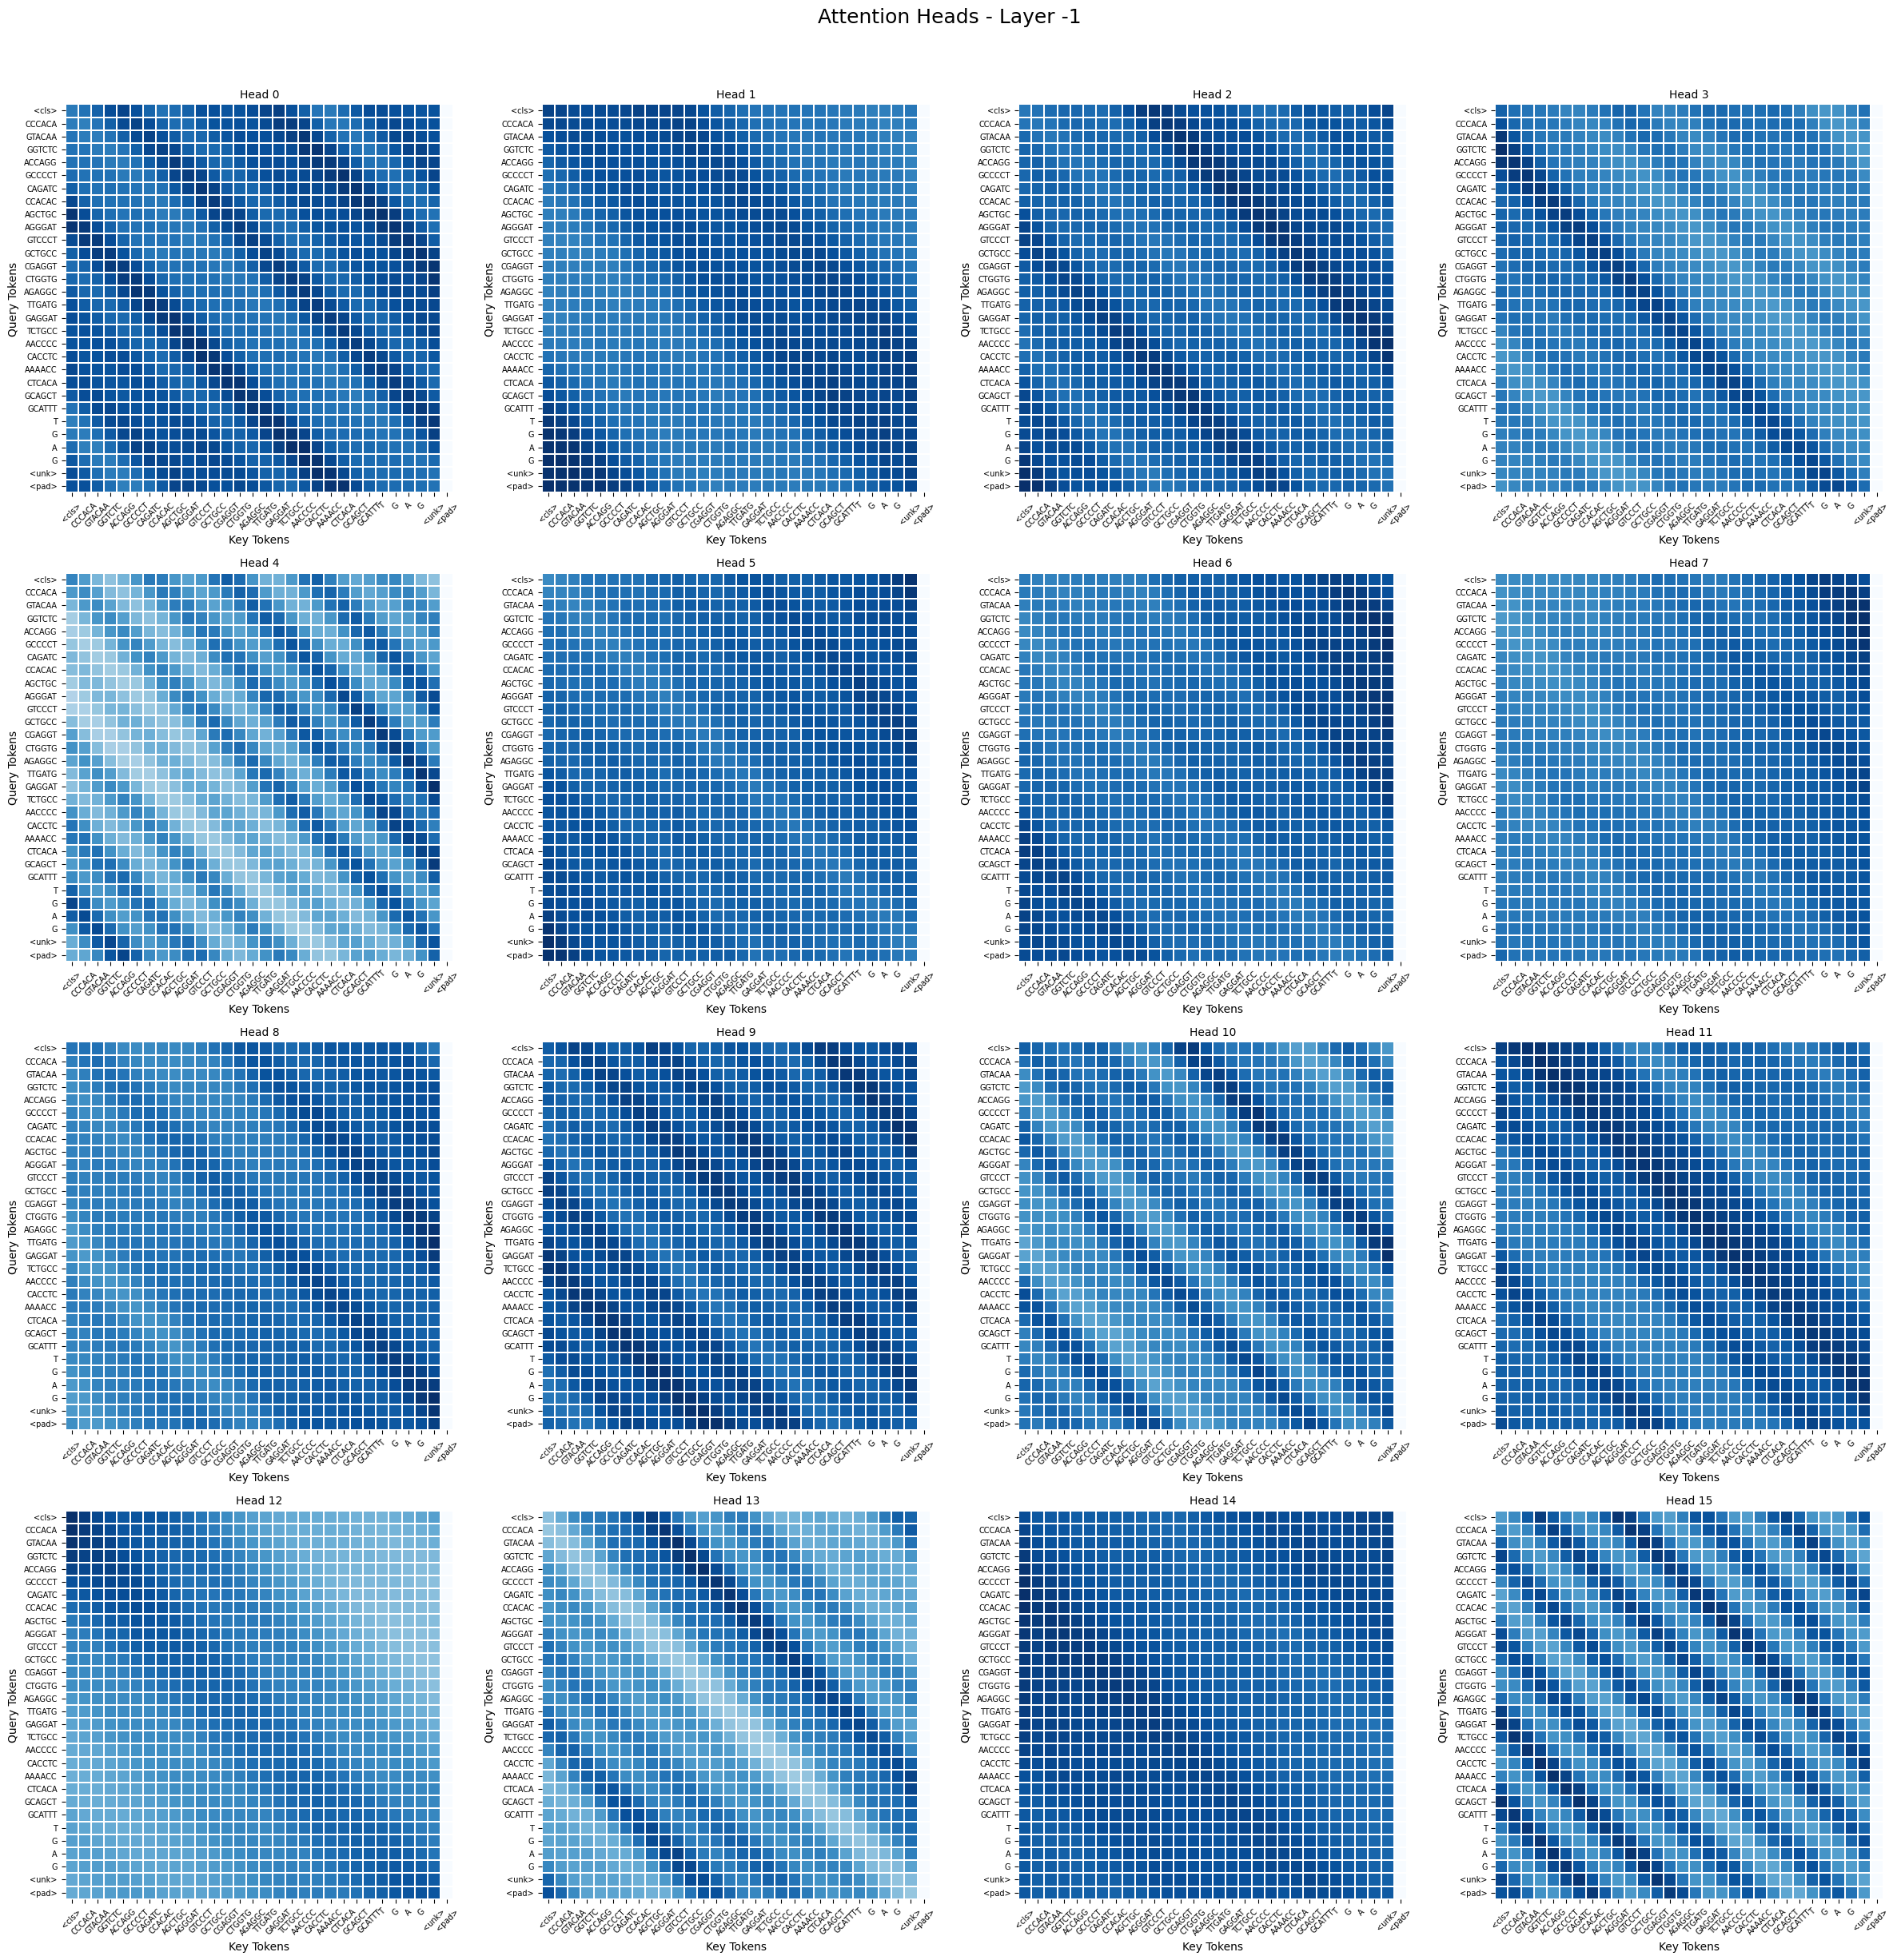

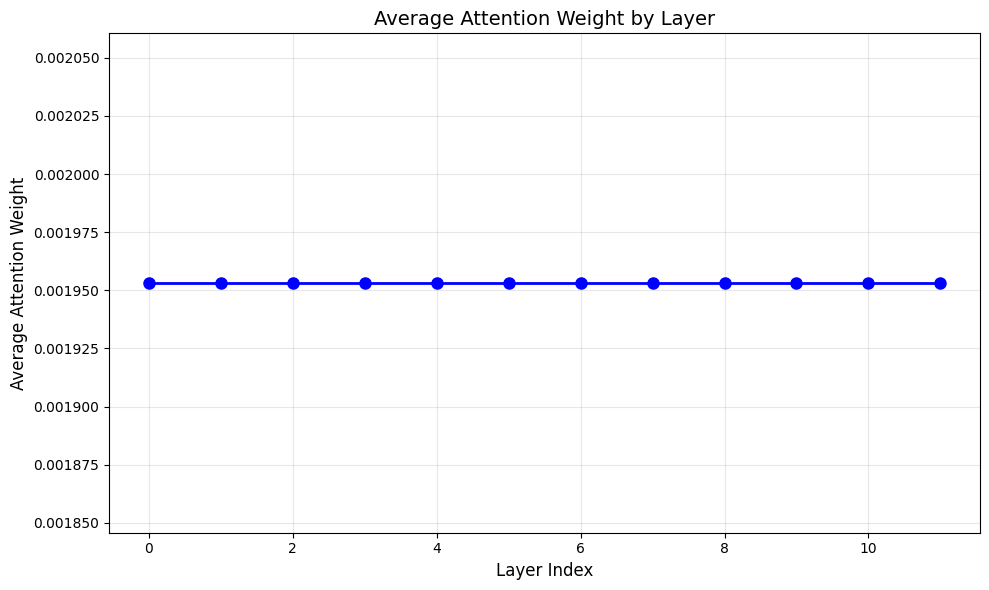

In [25]:
# Get a sample from your test dataset for visualization
sample_batch = next(iter(torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)))
sample_input_ids = sample_batch['input_ids']

# Visualize single attention head
#visualize_attention_heatmap(attention_weights, tokenizer, sample_input_ids, layer_idx=-1, head_idx=0, sample_idx=0)

# Visualize multiple heads
visualize_multiple_heads(attention_weights, tokenizer, sample_input_ids,num_heads=16,layer_idx=-1, sample_idx=0)

# Plot attention summary across layers
plot_attention_summary(attention_weights)
